<a href="https://colab.research.google.com/github/chenoa23/NLP-Projects/blob/main/Buildling_a_Recommendation_Engine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Assignment: Building a Recommendation Engine with a New Dataset
Chenoa Nussberger\
Lauren Coba


---
https://www.kaggle.com/datasets/mayurkadam9833/top-100-imdb-movies

**Find and Explore a New Dataset:**

- Select a dataset from platforms like Kaggle or any other source. Look for a dataset with a text column that can be used for generating word embeddings (e.g., movie descriptions, product reviews, book summaries, etc.).
- Download and load the dataset using pandas.
- Perform an initial exploration to understand the structure of the dataset and identify key columns that will be useful for building the recommender system.

**Preprocess the Text Data:**

- Apply the same robust text preprocessing steps as discussed in the article:
Lowercase transformation

  - Tokenization
  - Stopwords removal
  - Lemmatization
  - Store the preprocessed text in a new column named processed_text in your DataFrame.

**Create Word Embeddings:**

- Use Word2Vec to create word embeddings for your preprocessed text.
- Generate embeddings for each item in your dataset by averaging the word vectors.
- Check for any invalid embeddings and filter them out if necessary.

**Calculate Similarity:**

- Choose a similarity metric such as Cosine Similarity, Jaccard Similarity, or Euclidean Similarity.
- Calculate the similarity between items based on their embeddings and create a similarity matrix.

**Build the Recommender Function:**

- Create a function that takes an item (e.g., movie title or product name) as input and returns a list of the top 10 most similar items based on the similarity matrix.

**Reflection:**

- Write a reflection in your own words that includes the following sections:
  1. Aha! (New Things Learned): Share any new techniques or concepts that were unfamiliar to you before this assignment.
  2. Huh? (Confusions): Note any areas of confusion or parts of the assignment that were difficult to grasp.
  3. Cool!: Highlight the parts of the project you found particularly interesting or enjoyable.
  4. Gotcha! (Changed Perspective): Describe any preconceived notions that changed as a result of completing this assignment.
  5. Summary: Summarize what you have learned and how you can apply this knowledge to other projects or future work.

**Submit Your Work:**

- Upload your code, results, and reflection as a Jupyter Notebook or PDF document.
- Ensure that the code is well-commented and easy to follow.
- Include visualizations and explanations wherever necessary.


## Step 1: Find and Explore a New Dataset:

In [ ]:
# Mount Google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

# Loading the dataset
url = "/content/drive/MyDrive/CAI2300C/TOP 100 IMDB MOVIES.csv"
df = pd.read_csv(url)

# Displaying the first few rows of the dataset
df.head()

,rank,title,description,genre,rating,year
0,18,Spider-Man: Across the Spider-Verse,"Miles Morales catapults across the Multiverse,...","['Animation', 'Action', 'Adventure']",8.7,2023
1,32,Oppenheimer,"The story of American scientist, J. Robert Opp...","['Biography', 'Drama', 'History']",8.6,2023
2,77,Joker,A mentally troubled stand-up comedian embarks ...,"['Crime', 'Drama', 'Thriller']",8.4,2019
3,76,Avengers: Endgame,After the devastating events of Avengers: Infi...,"['Action', 'Adventure', 'Drama']",8.4,2019
4,37,Parasite,Greed and class discrimination threaten the ne...,"['Drama', 'Thriller']",8.5,2019


## Step 2: Preprocess the Text Data

In [ ]:
# Fill missing values in 'description' with an empty string
df['description'] = df['description'].fillna('')

# Display the first 5 rows of the 'description' column
df['description'].head()

,description
0,"Miles Morales catapults across the Multiverse,..."
1,"The story of American scientist, J. Robert Opp..."
2,A mentally troubled stand-up comedian embarks ...
3,After the devastating events of Avengers: Infi...
4,Greed and class discrimination threaten the ne...


In [ ]:
# Import necessary libraries for text preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download necessary NLTK data files (only need to run once)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Define a text preprocessing function
def preprocess_text(text):
    # Convert to string if it's not already
    if not isinstance(text, str):
        text = str(text)

    # 1. Lowercase the text
    text = text.lower()

    # 2. Tokenize the text
    tokens = word_tokenize(text)

    # 3. Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word.isalnum() and word not in stop_words]

    # 4. Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return tokens

# Ensure all values in 'description' are strings
df['tokenized_description'] = df['description'].astype(str)

# Apply the text preprocessing function directly to the 'overview' column
df['processed_text'] = df['tokenized_description'].apply(preprocess_text)

# Display the first 5 rows of the 'description' column after preprocessing
df['processed_text'].head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,processed_text
0,"[mile, morale, catapult, across, multiverse, e..."
1,"[story, american, scientist, robert, oppenheim..."
2,"[mentally, troubled, comedian, embarks, downwa..."
3,"[devastating, event, avenger, infinity, war, 2..."
4,"[greed, class, discrimination, threaten, newly..."


# Step 3: Create Word Embeddings



In [ ]:
# Create a Word2Vec model
model = Word2Vec(sentences=df['tokenized_description'], vector_size=100, window=5, min_count=1, workers=4)

# Display the vocabulary size
print(f"Vocabulary size: {len(model.wv.index_to_key)}")

Vocabulary size: 72


In [ ]:
# Create a Word2Vec model using the tokenized 'overview' column
from gensim.models import Word2Vec

# Create the Word2Vec model
model = Word2Vec(sentences=df['description'], vector_size=100, window=5, min_count=1, workers=4)

# Display the vocabulary size
print(f"Vocabulary size: {len(model.wv.index_to_key)}")

# Extract 10 words from the model's vocabulary
words = model.wv.index_to_key[:10]

# Create a DataFrame to display words and their embeddings
word_embeddings = [model.wv[word] for word in words]
embeddings_df = pd.DataFrame(word_embeddings, index=words)

# Display the DataFrame with 10 words and their corresponding embeddings
print(embeddings_df)

Vocabulary size: 72
         0         1         2         3         4         5         6   \
  -0.113190  0.183227  0.109590  0.160015  0.005045 -0.172468  0.174303   
e -0.128596  0.193169  0.113450  0.162020  0.024291 -0.177825  0.174538   
a -0.124611  0.203238  0.107163  0.161369  0.023658 -0.174384  0.179141   
t -0.115471  0.179824  0.098645  0.136598  0.018195 -0.158692  0.159938   
i -0.119257  0.183099  0.096695  0.146744  0.018159 -0.159150  0.167851   
o -0.125071  0.186952  0.105116  0.142104  0.005652 -0.170125  0.173083   
r -0.102826  0.173667  0.100918  0.146195  0.013480 -0.160967  0.168141   
n -0.115913  0.194231  0.122613  0.170432  0.013053 -0.181086  0.185446   
s -0.126913  0.193714  0.109695  0.160993  0.022751 -0.165079  0.179536   
h -0.117945  0.172856  0.096708  0.156864  0.012671 -0.172384  0.158866   

         7         8         9   ...        90        91        92        93  \
   0.360845 -0.235153 -0.253595  ...  0.154597  0.082122  0.057949 -0.0948

In [ ]:
# Function to generate an embedding for each movie overview
def get_movie_embedding(tokenized_text, model, embedding_size=100):
    # Get word embeddings for each word in the tokenized text
    valid_embeddings = [model.wv[word] for word in tokenized_text if word in model.wv]

    # If no valid embeddings, return a zero vector of the same size as the word vectors
    if len(valid_embeddings) == 0:
        return np.zeros(embedding_size)

    # Otherwise, return the mean of the valid embeddings
    return np.mean(valid_embeddings, axis=0)

# Apply the function to generate embeddings for each movie
# Make sure to define the embedding size to match the model's vector size
embedding_size = model.vector_size
df['movie_embedding'] = df['tokenized_description'].apply(lambda x: get_movie_embedding(x, model, embedding_size=embedding_size))


In [ ]:
# Check for invalid embeddings (e.g., NaNs or wrong shapes)
invalid_embeddings = df['movie_embedding'].apply(lambda x: x.shape[0] != embedding_size or np.any(np.isnan(x)))

# Print the number of invalid embeddings
print(f"Number of invalid embeddings: {invalid_embeddings.sum()}")

# Filter out invalid embeddings, if any
df = df[~invalid_embeddings]

Number of invalid embeddings: 0


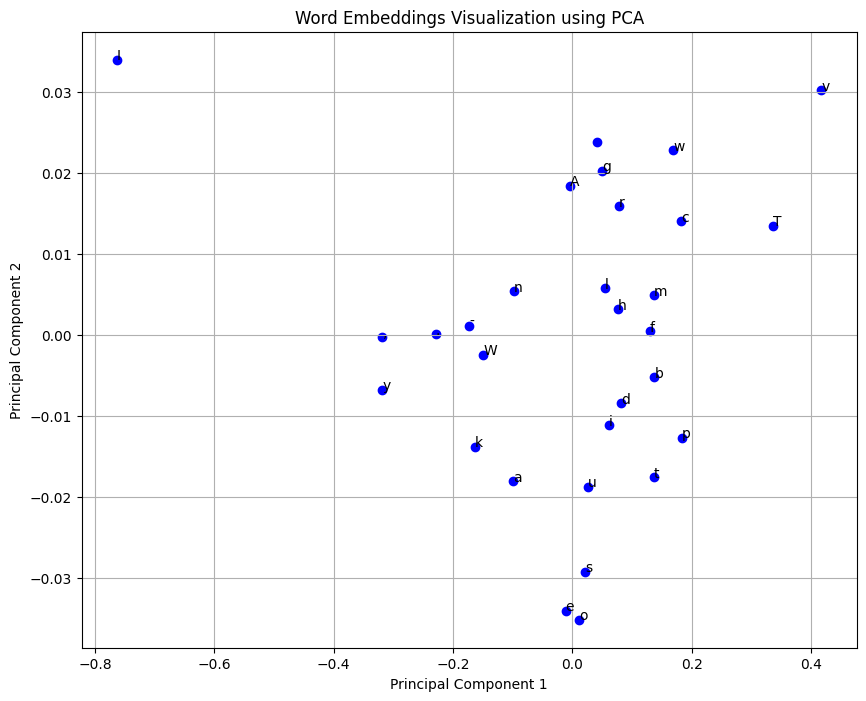

In [ ]:
# Import necessary libraries for visualization
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Select 30 random words from the vocabulary
words = list(model.wv.index_to_key)[:30]

# Get the word embeddings for these words
word_vectors = [model.wv[word] for word in words]

# Use PCA to reduce the word vectors to 2 dimensions
pca = PCA(n_components=2)
word_vectors_pca = pca.fit_transform(word_vectors)

# Create a scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(word_vectors_pca[:, 0], word_vectors_pca[:, 1], c='blue')

# Annotate each point with the word
for i, word in enumerate(words):
    plt.annotate(word, xy=(word_vectors_pca[i, 0], word_vectors_pca[i, 1]))

# Display the plot
plt.title("Word Embeddings Visualization using PCA")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid()
plt.show()

## Step 4: Calculate Similarity



In [ ]:
# Calculate cosine similarity between movie embeddings
embeddings_matrix = np.vstack(df['movie_embedding'].values)
cosine_sim = cosine_similarity(embeddings_matrix)

# Display the shape of the similarity matrix
print(f"Cosine similarity matrix shape: {cosine_sim.shape}")

Cosine similarity matrix shape: (100, 100)


In [ ]:
# Calculate cosine similarity between movie embeddings
embeddings_matrix = np.vstack(df['movie_embedding'].values)
cosine_sim = cosine_similarity(embeddings_matrix)

# Create a DataFrame for the cosine similarity matrix
cosine_sim_df = pd.DataFrame(cosine_sim, index=df['title'], columns=df['title'])

# Display the first 30 movies and their similarities
cosine_sim_df_subset = cosine_sim_df.iloc[:30, :30]
cosine_sim_df_subset.head()

title,Spider-Man: Across the Spider-Verse,Oppenheimer,Joker,Avengers: Endgame,Parasite,Capernaum,Avengers: Infinity War,Spider-Man: Into the Spider-Verse,Coco,Your Name.,...,WALL·E,The Dark Knight,The Prestige,The Lives of Others,Eternal Sunshine of the Spotless Mind,Oldboy,The Lord of the Rings: The Return of the King,The Lord of the Rings: The Two Towers,The Pianist,City of God
title,,,,,,,,,,,,,,,,,,,,,
Spider-Man: Across the Spider-Verse,1.000000,0.999993,0.999987,0.999996,0.999994,0.999994,0.999996,0.999994,0.999992,0.999995,...,0.999993,0.999996,0.999993,0.999992,0.999996,0.999991,0.999985,0.999993,0.999992,0.999994
Oppenheimer,0.999993,1.000000,0.999988,0.999994,0.999994,0.999992,0.999993,0.999994,0.999991,0.999994,...,0.999993,0.999993,0.999992,0.999992,0.999992,0.999994,0.999984,0.999990,0.999986,0.999992
Joker,0.999987,0.999988,1.000000,0.999988,0.999993,0.999987,0.999993,0.999991,0.999992,0.999994,...,0.999995,0.999992,0.999992,0.999992,0.999985,0.999991,0.999992,0.999993,0.999986,0.999990
Avengers: Endgame,0.999996,0.999994,0.999988,1.000000,0.999994,0.999997,0.999996,0.999995,0.999996,0.999997,...,0.999993,0.999993,0.999995,0.999996,0.999994,0.999994,0.999987,0.999992,0.999993,0.999994
Parasite,0.999994,0.999994,0.999993,0.999994,1.000000,0.999992,0.999996,0.999994,0.999995,0.999996,...,0.999998,0.999994,0.999995,0.999993,0.999989,0.999994,0.999985,0.999991,0.999987,0.999990


## Step 5: Build the Recommender Function



In [ ]:
# Create a mapping from movie title to index
movie_indices = pd.Series(df.index, index=df['title']).drop_duplicates()

# Function to recommend movies based on cosine similarity
def recommend_movies(title, cosine_sim=cosine_sim, df=df, movie_indices=movie_indices):
    # Get the index of the movie that matches the title
    idx = movie_indices[title]

    # Get the pairwise similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the indices of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return df['title'].iloc[movie_indices]

# Example: Recommend movies similar to 'Spider-Man: Across the Spider-Verse'
recommendations = recommend_movies('Spider-Man: Across the Spider-Verse')
print(recommendations)

70              The Shining
52             Forrest Gump
37               The Matrix
51            The Lion King
93    It's a Wonderful Life
94               Casablanca
3         Avengers: Endgame
19                 3 Idiots
12         Django Unchained
16                Inception
Name: title, dtype: object


Reflection:

Write a reflection in your own words that includes the following sections:
- Aha! (New Things Learned):
Share any new techniques or concepts that were unfamiliar to you before this assignment.

During this project, I learned how to create word embeddings using the Word2Vec model. I had heard about word embeddings before, but this was my first hands-on experience using them to build a recommender system.

---

- Huh? (Confusions): Note any areas of confusion or parts of the assignment that were difficult to grasp.

I did not find any parts confusing, but I need to practice the code more and learn how to code it myself. Gaining a deeper understanding of how each step works will help me feel more confident in applying these techniques in the future.

---

- Cool!: Highlight the parts of the project you found particularly interesting or enjoyable.

What I found particularly enjoyable was seeing how similar items could be identified based on their word embeddings. It was fascinating to see how words in the text were transformed into vectors and how these vectors could represent relationships between items.

---

- Gotcha! (Changed Perspective): Describe any preconceived notions that changed as a result of completing this assignment.

Before this assignment, I had a simplistic view of how recommendation systems worked. I assumed they were mainly based on explicit data like ratings or user preferences. However, after completing this project, I realized how powerful natural language processing and text data can be in building recommendations.

---

- Summary: Summarize what you have learned and how you can apply this knowledge to other projects or future work.

Overall, this project introduced me to word embeddings, text preprocessing, and similarity metrics, all of which are important techniques in natural language processing. I learned how to prepare text data for machine learning models and how to calculate item similarity based on word vectors.